# Plot song and fbehav temporal features conditioned on strain

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from aux import get_seg
from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS


# STRAINS = ['NM91', 'ZH23']
# STRAINS = ['CM07', 'CSTul']
STRAINS = ['N30', 'ZW109']

STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

In [2]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [3]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in ISTRAIN]

tr_lens = [len(df_tr) for df_tr in dfs_tr]

df_behav = None

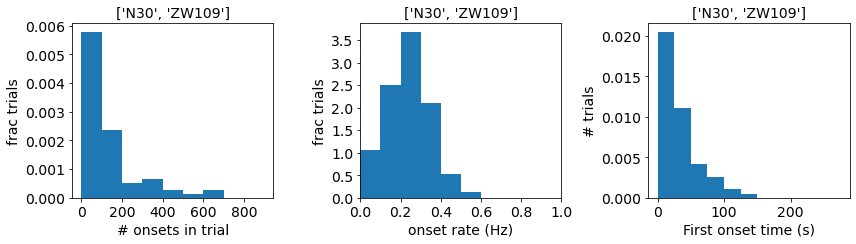

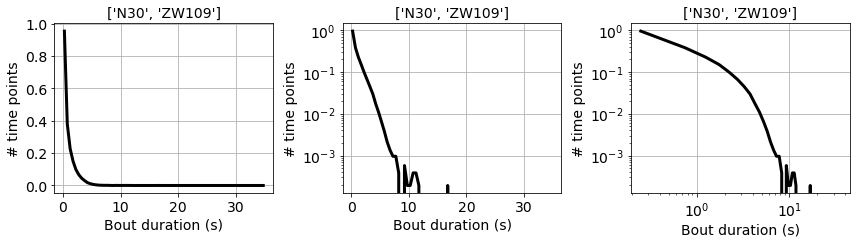

In [4]:
# distribution of song onsets
nonsets = []
rate_onsets = []
t_first_onsets = []

bout_durs_all = []

for df_tr in dfs_tr:
    singing = ~np.array(df_tr['Q']).astype(bool)
    seg, bds = get_seg(singing, min_gap=1)
    nonset = len(seg)
    
    nonsets.append(nonset)
    rate_onsets.append(nonset/(DT*len(df_tr)))
    t_first_onsets.append(bds[0][0]*DT)
    
    bout_durs_all.append(DT*(bds[:, 1] - bds[:, 0]))
    
bout_durs_all = cc(bout_durs_all)

fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True)
axs[0].hist(nonsets, bins=np.linspace(0, 900, 10), density=True)
axs[0].set_xlabel('# onsets in trial')
axs[0].set_ylabel('frac trials')

axs[1].hist(rate_onsets, bins=np.linspace(0, 1, 11), density=True)
axs[1].set_xlim(0, 1)
axs[1].set_xlabel('onset rate (Hz)')
axs[1].set_ylabel('frac trials')

axs[2].hist(t_first_onsets, bins=np.linspace(0, 275, 12), density=True)
axs[2].set_xlabel('First onset time (s)')
axs[2].set_ylabel('# trials')

for ax in axs:
    set_plot(ax, title=f'{STRAINS}', font_size=14)
    
    
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True)
cts, bins = np.histogram(bout_durs_all, bins=np.linspace(0, 35, 71), density=True)
binc = .5*(bins[:-1] + bins[1:])

axs[0].plot(binc, cts, lw=3, c='k')

axs[1].plot(binc, cts, lw=3, c='k')
axs[1].set_yscale('log')

axs[2].plot(binc, cts, lw=3, c='k')
axs[2].set_xscale('log')
axs[2].set_yscale('log')

for ax in axs:
    ax.set_xlabel('Bout duration (s)')
    ax.set_ylabel('# time points')
    ax.grid()
    set_plot(ax, title=f'{STRAINS}', font_size=14)

# Frac trials singing and singing in each mode over time

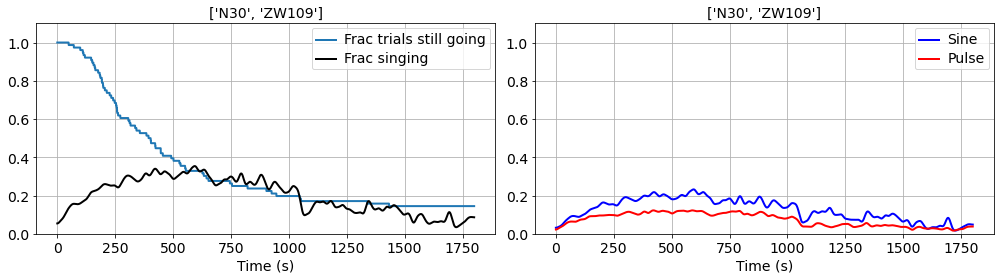

In [5]:
from scipy.ndimage import gaussian_filter1d as smooth
SMOOTH = int(round(10/DT))

songs = np.nan * np.ones((len(dfs_tr), np.max(tr_lens)))
for ctr, df_tr in enumerate(dfs_tr):
    song = np.zeros(len(df_tr), dtype=int)
    song[np.array(df_tr['S'], dtype=bool)] = 1
    song[np.array(df_tr['P'] | df_tr['F'], dtype=bool)] = 2
    songs[ctr, :len(df_tr)] = song
    
frac_ongoing = np.mean(~np.isnan(songs), axis=0)

fig, axs = plt.subplots(1, 2, figsize=(14, 4), tight_layout=True)
axs[0].plot(DT*np.arange(songs.shape[1]), frac_ongoing, lw=2)

frac_singing = smooth(np.mean(songs > 0, axis=0)/frac_ongoing, SMOOTH)

axs[0].plot(DT*np.arange(songs.shape[1]), frac_singing, lw=2, c='k')
axs[0].set_ylim(0, 1.1)
axs[0].set_xlabel('Time (s)')
# axs[0].set_ylabel('Fraction trials still going')
axs[0].legend(['Frac trials still going', 'Frac singing'])

frac_sine = smooth(np.mean(songs == 1, axis=0)/frac_ongoing, SMOOTH)
frac_pulse = smooth(np.mean(songs == 2, axis=0)/frac_ongoing, SMOOTH)

axs[1].plot(DT*np.arange(songs.shape[1]), frac_sine, lw=2, c='b')
axs[1].plot(DT*np.arange(songs.shape[1]), frac_pulse, lw=2, c='r')
axs[1].set_ylim(0, 1.1)

axs[1].set_xlabel('Time (s)')
axs[1].legend(['Sine', 'Pulse'])

for ax in axs:
    ax.grid()
    set_plot(ax, title=f'{STRAINS}', font_size=14)

# Avg female movement speed over time

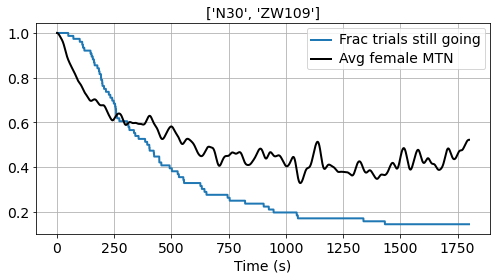

In [6]:
from scipy.ndimage import gaussian_filter1d as smooth
SMOOTH = int(round(10/DT))

mtns = np.nan * np.ones((len(dfs_tr), np.max(tr_lens)))
for ctr, df_tr in enumerate(dfs_tr):
    mtn = np.array(np.sqrt(df_tr['FFV']**2 + df_tr['FLS']**2))
    mtns[ctr, :len(df_tr)] = mtn 
    
# normalize motion
# for ctr in range(len(mtns)):
#     mtns[ctr, :] = mtns[ctr, :] / np.nanmean(mtns[ctr, :])
    
frac_ongoing = np.mean(~np.isnan(songs), axis=0)

mtn_mean = smooth(np.nanmean(mtns, axis=0), SMOOTH)
mtn_mean /= mtn_mean.max()

fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)
ax.plot(DT*np.arange(songs.shape[1]), frac_ongoing, lw=2)
ax.plot(DT*np.arange(songs.shape[1]), mtn_mean, lw=2, c='k')
ax.set_xlabel('Time (s)')
ax.legend(['Frac trials still going', 'Avg female MTN'])

ax.grid()
set_plot(ax, title=f'{STRAINS}', font_size=14)

## Temporal autocovariance function of female motion variable

In [5]:
from time_stats import xcov_multi_with_confidence

lag_bak = int(round(30*FPS))
lag_fwd = int(round(30*FPS))

durs = np.array([len(df_tr) for df_tr in dfs_tr])*DT

covs_mtn = []
for df_tr in dfs_tr:
    sys.stdout.write('.')
    mtn = np.array(np.sqrt(df_tr['FFV']**2 + df_tr['FLS']**2))
    
    cov_mtn = xcov_multi_with_confidence([mtn], [mtn], lag_backward=lag_bak, lag_forward=lag_fwd, pre_norm=False, scale=True)[0]
    covs_mtn.append(cov_mtn)
    
covs_mtn = np.array(covs_mtn)

.......................................................................

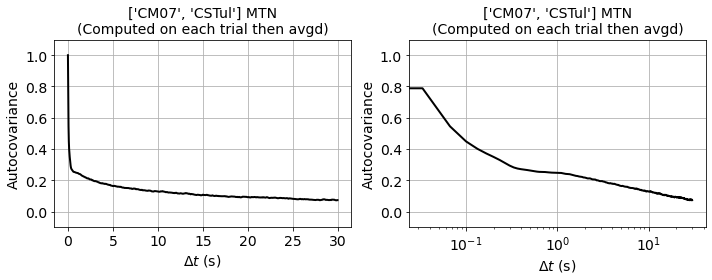

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

dur_mat = np.tile(durs[:, None], (1, covs_mtn.shape[1]))
dur_mat[np.isnan(covs_mtn)] = np.nan
weight_mat = dur_mat / np.nansum(dur_mat, 0)

covs_mtn_mean = np.nansum(covs_mtn*weight_mat, axis=0)

t_cov = np.arange(-lag_bak, lag_fwd) * DT

axs[0].plot(t_cov[t_cov >= 0], covs_mtn_mean[t_cov >= 0], lw=2, c='k')
axs[1].semilogx(t_cov[t_cov >= 0], covs_mtn_mean[t_cov >= 0], lw=2, c='k')

for ax in axs:
    ax.set_ylim(-.1, 1.1)
    ax.set_xlabel('$\Delta t$ (s)')
    ax.set_ylabel('Autocovariance')
    ax.set_title(f'{STRAINS} MTN\n(Computed on each trial then avgd)')
    ax.grid()
    
    set_plot(ax, font_size=14)